<a href="https://colab.research.google.com/github/hipeoplea/Sai/blob/main/Sai_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt


column_names = [
    "class",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat"
]

df = pd.read_csv("agaricus-lepiota.data", header=None, names=column_names)

df["class"] = df["class"].map({"e": 0, "p": 1}) #ядовитый гриб 1 съедобный 0

df.describe()

,class
count,8124.000000
mean,0.482029
std,0.499708
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Отделяем целевую переменную и отбираем случайным образом $\sqrt{n}$ признаков.


In [ ]:
X_full = df.drop("class", axis=1)
y_full = df["class"].values
n_features = X_full.shape[1]
k_features = math.ceil(math.sqrt(n_features))

print("Всего признаков:", n_features)
print("Выбираем sqrt(n) =", k_features)


random.seed(42)
selected_features = random.sample(list(X_full.columns), k_features)

print("\nВыбранные признаки:")
for f in selected_features:
    print(f)
X = X_full[selected_features]
X.head()

Всего признаков: 22
Выбираем sqrt(n) = 5

Выбранные признаки:
population
bruises
cap-shape
gill-color
gill-size


,population,bruises,cap-shape,gill-color,gill-size
0,s,t,x,k,n
1,n,t,x,k,b
2,n,t,b,n,b
3,s,t,x,n,n
4,a,f,x,k,b


In [ ]:
np.random.seed(42)
indices = np.arange(len(y_full))
np.random.shuffle(indices)

test_count = int(len(y_full) * 0.2)
test_idx = indices[:test_count]
train_idx = indices[test_count:]

X_train = X.iloc[train_idx].reset_index(drop=True)
X_test  = X.iloc[test_idx].reset_index(drop=True)
y_train = y_full[train_idx]
y_test  = y_full[test_idx]

print("Форма X_train:", X_train.shape)
print("Форма X_test :", X_test.shape)

print("\nРаспределение классов в train:")
print(pd.Series(y_train).value_counts())
print("\nРаспределение классов в test:")
print(pd.Series(y_test).value_counts())


Форма X_train: (6500, 5)
Форма X_test : (1624, 5)

Распределение классов в train:
0    3365
1    3135
Name: count, dtype: int64

Распределение классов в test:
0    843
1    781
Name: count, dtype: int64


Структура узла дерева (`class Node`)

Каждый узел дерева представляется объектом класса `Node`:

- `is_leaf` — флаг, является ли узел листом.
- `prediction` — предсказываемый класс (0 или 1) в листе.
- `pos_prob` — оценка вероятности положительного класса (доля единиц в листе).
- `feature` — имя признака, по которому происходит разбиение в данном узле.
- `children` — словарь вида `значение_признака -> поддерево (Node)`.

In [ ]:
class Node:
    def __init__(self, is_leaf=False, prediction=None, pos_prob=None,
                 feature=None, children=None):
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.pos_prob = pos_prob
        self.feature = feature
        self.children = children or {}


Функция `entropy(y)` вычисляет энтропию множества меток `y`:

- Находятся уникальные значения классов и их частоты.
- Считаются вероятности `p_i` каждого класса.
- Энтропия вычисляется по формуле:
  $$
  H = -\sum p_i \log_2 p_i
  $$
  Чем более «смешаны» классы в узле, тем больше энтропия.

Функция `information_gain(parent_y, splits)`:

- `parent_y` — метки до разбиения.
- `splits` — список подмножеств `y` после разбиения по признаку.
- Считается:
  - энтропия родительского узла,
  - средневзвешенная энтропия дочерних узлов.
- Информационный выигрыш:
  $$
  IG = H(\text{parent}) - \sum w_j H(\text{child}_j)
  $$
  где `w_j` — доля объектов в j-том подмножестве.


In [ ]:
def entropy(y):
    if len(y) == 0:
        return 0.0
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum([p * math.log2(p) for p in probs if p > 0])


def information_gain(parent_y, splits):
    H_parent = entropy(parent_y)
    total = len(parent_y)
    H_children = 0.0

    for subset in splits:
        if len(subset) == 0:
            continue
        weight = len(subset) / total
        H_children += weight * entropy(subset)

    return H_parent - H_children

Функция `best_split(X, y, features)`:

- Перебирает все признаки из списка `features`.
- Для каждого признака:
  - Берёт все уникальные значения признака.
  - Для каждого значения формирует маску `idx` и соответствующее подмножество меток `y[idx]`.
  - Вычисляет информационный выигрыш от такого разбиения.
- Возвращает:
  - `best_feature` — имя признака с максимальным информационным выигрышем,
  - `best_gain` — значение информационного выигрыша,
  - `best_splits_indices` — словарь `значение_признака -> булев массив индексов`.


In [ ]:
def best_split(X, y, features):
    best_feature = None
    best_gain = -1
    best_splits_indices = None

    for feature in features:
        values = X[feature].unique()
        splits_indices = {}
        splits_y = []

        for v in values:
            idx = (X[feature] == v)
            splits_indices[v] = idx
            splits_y.append(y[idx])

        gain = information_gain(y, splits_y)

        if gain > best_gain:
            best_gain = gain
            best_feature = feature
            best_splits_indices = splits_indices

    return best_feature, best_gain, best_splits_indices


In [ ]:
features_list = list(X_train.columns)
bf, bg, _ = best_split(X_train, y_train, features_list)
print("Лучший признак:", bf, "информационный выигрыш:", bg)


Лучший признак: gill-color информационный выигрыш: 0.4173850558243196


Функция `create_leaf(y)`:

- Находит наиболее частый класс в `y` (majority class).
- Вычисляет долю единиц `pos_prob = mean(y)`.
- Создаёт объект `Node` с:
  - `is_leaf=True`,
  - `prediction = majority_class`,
  - `pos_prob = доля положительных классов`.

Этот узел используется как конечное состояние рекурсии и как «заглушка» при остановке роста дерева.


In [ ]:
def create_leaf(y):
    values, counts = np.unique(y, return_counts=True)
    majority_class = values[np.argmax(counts)]
    pos_prob = np.mean(y)  # доля 1
    return Node(
        is_leaf=True,
        prediction=int(majority_class),
        pos_prob=float(pos_prob)
    )

Функция `build_tree(X, y, features, max_depth=None, min_samples_split=2, depth=0)`:
1. **Условия остановки:**
   - В узле все объекты одного класса.
   - Число объектов меньше `min_samples_split`.
   - Достигнута максимальная глубина `max_depth` (если задана).
   - Не осталось признаков для разбиения.

   Во всех этих случаях возвращается лист (`create_leaf(y)`).

2. **Выбор признака для разбиения:**
   - Вызывается `best_split`.
   - Если информационный выигрыш неположительный, создаётся лист.

3. **Создание внутреннего узла:**
   - Узел с полем `feature = best_feature`.
   - `children` изначально пустой словарь.

4. **Рекурсивное построение поддеревьев:**
   - Формируется список `remaining_features` — признаки без `best_feature`.
   - Для каждого значения лучшего признака:
     - Отбираются строки `X_child = X[idx]` и `y_child = y[idx]`.
     - Из `X_child` удаляется столбец `best_feature`.
     - Рекурсивно вызывается `build_tree` для дочернего узла.
     - Дочерний узел записывается в `children[value]`.

Таким образом строится **небинарное дерево**, где каждая развилка может иметь несколько исходящих ветвей по разным значениям категориального признака.


In [ ]:

def build_tree(X, y, features, max_depth=None, min_samples_split=2, depth=0):

    if len(np.unique(y)) == 1:
        return create_leaf(y)

    if len(y) < min_samples_split:
        return create_leaf(y)

    if max_depth is not None and depth >= max_depth:
        return create_leaf(y)

    if len(features) == 0:
        return create_leaf(y)

    best_feature, best_gain, best_splits_indices = best_split(X, y, features)

    if best_feature is None or best_gain <= 0:
        return create_leaf(y)

    node = Node(
        is_leaf=False,
        feature=best_feature,
        children={}
    )

    remaining_features = [f for f in features if f != best_feature]

    for value, idx in best_splits_indices.items():
        X_child = X[idx].drop(columns=[best_feature])
        y_child = y[idx]

        if len(y_child) == 0:
            child_node = create_leaf(y)
        else:
            child_node = build_tree(
                X_child,
                y_child,
                remaining_features,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                depth=depth + 1
            )

        node.children[value] = child_node

    return node


In [ ]:
features_list = list(X_train.columns)

tree = build_tree(
    X_train,
    y_train,
    features_list,
    max_depth=None,
    min_samples_split=5)

print("Дерево построено!")

Дерево построено!


In [ ]:
def print_tree(node, indent=""):
    if node.is_leaf:
        print(f"{indent}Leaf: class={node.prediction}, p(1)={node.pos_prob:.3f}")
    else:
        print(f"{indent}Node: split by feature = '{node.feature}'")
        for value, child in node.children.items():
            print(f"{indent}  if {node.feature} == {repr(value)}:")
            print_tree(child, indent + "    ")
print_tree(tree)

Node: split by feature = 'gill-color'
  if gill-color == 'p':
    Node: split by feature = 'population'
      if population == 'y':
        Node: split by feature = 'bruises'
          if bruises == 'f':
            Node: split by feature = 'gill-size'
              if gill-size == 'b':
                Leaf: class=1, p(1)=1.000
              if gill-size == 'n':
                Leaf: class=0, p(1)=0.000
          if bruises == 't':
            Leaf: class=0, p(1)=0.000
      if population == 'a':
        Leaf: class=0, p(1)=0.000
      if population == 'v':
        Node: split by feature = 'bruises'
          if bruises == 't':
            Node: split by feature = 'gill-size'
              if gill-size == 'n':
                Node: split by feature = 'cap-shape'
                  if cap-shape == 'f':
                    Leaf: class=0, p(1)=0.429
                  if cap-shape == 'x':
                    Leaf: class=1, p(1)=0.609
              if gill-size == 'b':
                Node: 

Функция `predict_one(node, x_row)`:

- Начинается с корня дерева.
- Пока текущий узел не является листом:
  - Берётся имя признака `feature = current.feature`.
  - Получается значение `value = x_row[feature]`.
  - Если `value` присутствует в `current.children`, переход к соответствующему дочернему узлу.
  - Если значение не найдено в `children`, используется «резервный» вариант:
    - возвращаются `prediction` и `pos_prob` текущего узла (или дефолты).
- Если достигнут лист:
  - Возвращаются `prediction` и `pos_prob` листа.


In [ ]:
def predict_one(node, x_row):
    current = node

    while not current.is_leaf:
        feature = current.feature
        value = x_row.get(feature, None)

        if value not in current.children:
            pred = current.prediction if current.prediction is not None else 1
            prob = current.pos_prob if current.pos_prob is not None else 0.5
            return pred, prob

        current = current.children[value]

    pred = current.prediction
    prob = current.pos_prob if current.pos_prob is not None else 0.5

    return pred, prob


Функция `predict(tree, X)`:
- Возвращает:
  - `y_pred` — массив предсказанных классов (0 или 1),
  - `y_score` — массив вероятностей класса 1 (оценка на основе `pos_prob` в листе).


In [ ]:
def predict(tree, X):
    y_pred = []
    y_score = []

    for _, row in X.iterrows():
        pred, score = predict_one(tree, row.to_dict())
        y_pred.append(pred)
        y_score.append(score)

    return np.array(y_pred), np.array(y_score)

Функция `classification_metrics(y_true, y_pred)`:
- Вычисляет:
  - `accuracy = (TP + TN) / (TP + TN + FP + FN)`
  - `precision = TP / (TP + FP)` (если знаменатель > 0),
  - `recall = TP / (TP + FN)` (если знаменатель > 0).
- Возвращает метрики и значения TP, FP, TN, FN.

In [ ]:
def classification_metrics(y_true, y_pred):
    TP = FP = TN = FN = 0

    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 1:
            TP += 1
        elif yt == 0 and yp == 0:
            TN += 1
        elif yt == 0 and yp == 1:
            FP += 1
        elif yt == 1 and yp == 0:
            FN += 1

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return accuracy, precision, recall, TP, FP, TN, FN

Функция `compute_roc_pr_auc(y_true, y_score)`:

1. Сортирует пары `(score, label)` по убыванию `score`.
2. Считает общее количество:
   - `P` — число положительных объектов,
   - `N` — число отрицательных объектов.
3. Проходит по отсортированному списку, по одному объекту:
   - При положительном классе увеличивает `TP`.
   - При отрицательном классе увеличивает `FP`.
   - На каждом шаге вычисляет:
     - TPR (True Positive Rate) = `TP / P` — то же, что Recall,
     - FPR (False Positive Rate) = `FP / N`,
     - Precision = `TP / (TP + FP)`.
   - Для ROC добавляет точку `(FPR, TPR)`.
   - Для PR добавляет точку `(Recall, Precision)`.

4. Для ROC-кривой добавляет конечную точку `(1.0, 1.0)` при необходимости.
5. Площадь под кривыми (AUC) считается методом трапеций:
   - Точки сортируются по оси X.
   - Последовательно суммируются площади трапеций.

В итоге мы получаем наборы точек


In [ ]:
def compute_roc_pr_auc(y_true, y_score):
    pairs = sorted(zip(y_score, y_true), key=lambda x: -x[0])
    scores_sorted = [p[0] for p in pairs]
    y_sorted = [p[1] for p in pairs]

    P = sum(y_sorted)
    N = len(y_sorted) - P

    roc_points = [(0.0, 0.0)]
    TP = 0
    FP = 0

    pr_points = []

    for score, label in zip(scores_sorted, y_sorted):
        if label == 1:
            TP += 1
        else:
            FP += 1

        TPR = TP / P if P > 0 else 0.0
        FPR = FP / N if N > 0 else 0.0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0

        roc_points.append((FPR, TPR))
        pr_points.append((TPR, precision))

    if roc_points[-1][0] != 1.0:
        roc_points.append((1.0, 1.0))

    def auc(points):
        area = 0.0
        for i in range(1, len(points)):
            x0, y0 = points[i-1]
            x1, y1 = points[i]
            area += (x1 - x0) * (y0 + y1) / 2.0
        return area

    roc_points_sorted = sorted(roc_points, key=lambda p: p[0])
    auc_roc = auc(roc_points_sorted)

    pr_points_sorted = sorted(pr_points, key=lambda p: p[0])
    auc_pr = auc(pr_points_sorted)

    return roc_points_sorted, pr_points_sorted, auc_roc, auc_pr

In [ ]:
y_pred, y_score = predict(tree, X_test)
accuracy, precision, recall, TP, FP, TN, FN = classification_metrics(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("TP, FP, TN, FN:", TP, FP, TN, FN)
roc_points, pr_points, auc_roc, auc_pr = compute_roc_pr_auc(y_test, y_score)

print("AUC-ROC:", auc_roc)
print("AUC-PR:", auc_pr)


Accuracy: 0.9486074780735497
Precision: 0.9476372924648787
Recall: 0.9458253664754621
TP, FP, TN, FN: 2968 164 3197 170
AUC-ROC: 0.9877079513460466
AUC-PR: 0.9798964297794458

Первые точки ROC: [(0.0, 0.0), (np.float64(0.0), np.float64(0.00031867431485022306)), (np.float64(0.0), np.float64(0.0006373486297004461)), (np.float64(0.0), np.float64(0.0009560229445506692)), (np.float64(0.0), np.float64(0.0012746972594008922)), (np.float64(0.0), np.float64(0.0015933715742511153)), (np.float64(0.0), np.float64(0.0019120458891013384)), (np.float64(0.0), np.float64(0.0022307202039515616)), (np.float64(0.0002975304968759298), np.float64(0.0022307202039515616)), (np.float64(0.0002975304968759298), np.float64(0.0025493945188017845))]

Первые точки PR: [(np.float64(0.00031867431485022306), 1.0), (np.float64(0.0006373486297004461), 1.0), (np.float64(0.0009560229445506692), 1.0), (np.float64(0.0012746972594008922), 1.0), (np.float64(0.0015933715742511153), 1.0), (np.float64(0.0019120458891013384), 1.0)

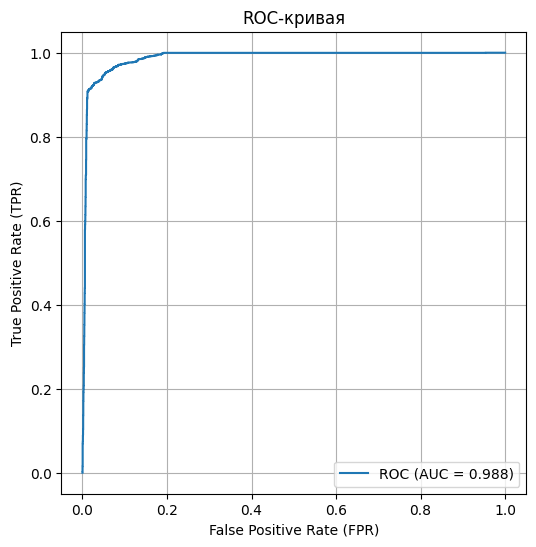

In [ ]:
roc_fpr = [float(x) for x, y in roc_points]
roc_tpr = [float(y) for x, y in roc_points]

plt.figure(figsize=(6, 6))
plt.plot(roc_fpr, roc_tpr, label=f"ROC (AUC = {auc_roc:.3f})")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-кривая")
plt.legend()
plt.grid(True)
plt.show()


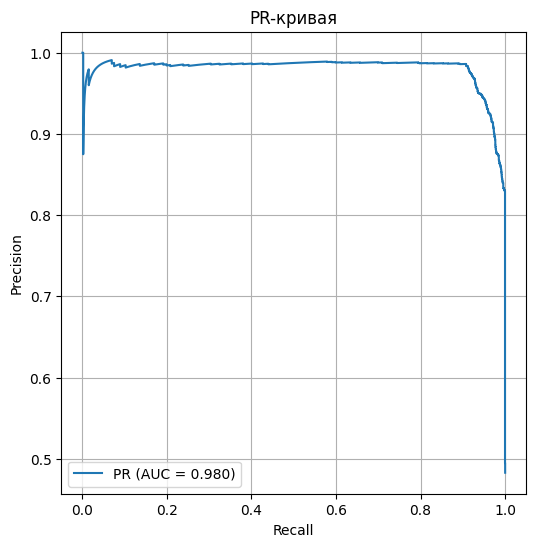

In [ ]:
pr_recall = [float(r) for r, p in pr_points]
pr_precision = [float(p) for r, p in pr_points]

plt.figure(figsize=(6, 6))
plt.plot(pr_recall, pr_precision, label=f"PR (AUC = {auc_pr:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-кривая")
plt.legend()
plt.grid(True)
plt.show()
